## Assignment 3


### Goals

- First: the original hashtags have been blanked out from the tweet. Build a predictive model that can predict the hashtag used based on the rest of the tweet text
- Second: show that your model can make predictions in a deployed streaming setting using Spark


#### Tasks
Using Spark, your task for this assignment is as follows:

- [X] Construct a historical data set using the provided stream
- [ ] Construct a predictive model to predict the used hashtag based on the tweet text
     - [X] load historical data 
     - [X] set histdata (.json) as dataframe
     - [X] featurization text_tweet
     - [ ] ...
- [ ] Use your trained model to show you can make predictions as the stream comes in

    * Important: get started with this as soon as possible. We will discuss text mining in more detail later on, but you can already start gathering your data
    * Make sure to set up Spark first using the instructions posted above if you haven't done so already
        * The streaming server is running at seppe.net:7778, as shown in the example notebooks

The stream is text-based with each line containing one tweet (one instance) formatted as a JSON dictionary with the following keys (features): "tweet_id" (id of the tweet, not to be used), "tweet_text" (the tweet with the hashtags blanked out) and "label" (the target) You can use extra data and libraries if you want, but this is not required You are strongly encouraged to build your model using spark.ml (MLlib), but you can use scikit-learn as a fallback if things don't work out
I.e. show that you can connect to the data source, preprocess/featurize incoming tweets, have your model predict the label, and show it, similar to "spark_streaming_example_predicting.py.ipynb" (but hopefully using a smarter, real predictive model) This means that you'll need to look for a way to save and load your trained model

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import nltk
import string
import wordcloud
import seaborn as sns
import spacy
impos

In [3]:
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [5]:
english_stemmer = SnowballStemmer('english')
nlp = spacy.load('es_core_news_sm')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amgiraldov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# Functions ==================================================================

def tokenize(text):
    doc = nlp(text)
    words = [t.orth_ for t in doc if not t.is_punct | t.is_stop]
    lexical_tokens = [t.lower() for t in words if t.isalpha()]
    stems = [english_stemmer.stem(token) for token in lexical_tokens]
    return stems

def tokenize1(text):
    doc = nlp(text)
    words = [t.orth_ for t in doc if not t.is_punct | t.is_stop]
    lexical_tokens = [t.lower() for t in words if t.isalpha()]
    return lexical_tokens


#### Load data

In [7]:
os.chdir('/Users/amgiraldov/OneDrive - KU Leuven/Advanced Analytics')
os.getcwd()

'/Users/amgiraldov/OneDrive - KU Leuven/Advanced Analytics'

In [8]:
# Load data from the training set
# ------------------------------------

df = pd.read_csv("tweet_00.csv", header = None)
df1 = pd.read_csv("tweet_01.csv", header = None)
df2 = pd.read_csv("tweet_02.csv", header = None)
df3 = pd.read_csv("tweet_03.csv", header = None)
df4 = pd.read_csv("tweet_04.csv", header = None)
df5 = pd.read_csv("tweet_05.csv", header = None)
df = pd.concat([df, df1, df2, df3, df4, df5]).drop_duplicates()

In [9]:
df.shape

(10949, 3)

In [10]:
df.columns = ['label', 'tweet_id', 'tweet_text']
dummyTag = pd.get_dummies(df["label"])
dummyTag = pd.concat([df[["tweet_id","tweet_text"]], dummyTag], axis = 1).drop_duplicates()

Text(0.5, 0, 'Hashtag')

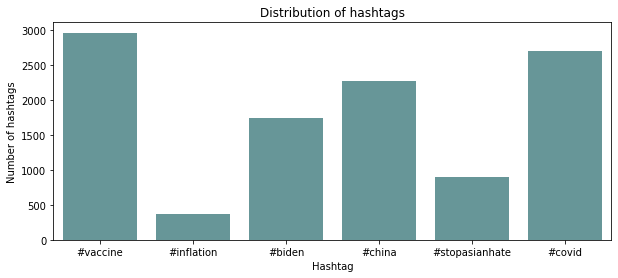

In [11]:
plt.figure(figsize=(10,4))
g2 = sns.countplot(x = 'label', data = df, color = 'cadetblue').set_title('Distribution of hashtags')
plt.ylabel("Number of hashtags")
plt.xlabel("Hashtag")

In [12]:
df['label'].value_counts()/10949

#vaccine          0.270801
#covid            0.246415
#china            0.207325
#biden            0.159010
#stopasianhate    0.082382
#inflation        0.034067
Name: label, dtype: float64

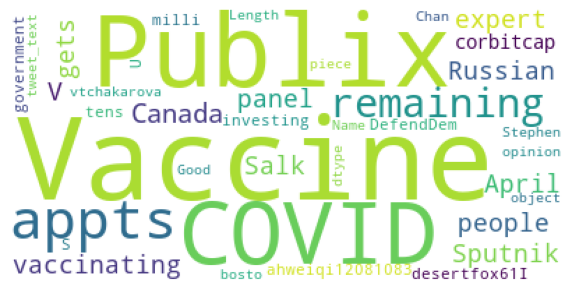

In [13]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=1000).generate(str(df['tweet_text']))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off');

In [14]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['https']
stop_words.extend(newStopWords)

In [15]:
def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k), stop_words = stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
common_words = get_top_n_words(df['tweet_text'], 30, 1)
for word, freq in common_words:
    print(word, freq)

co 9597
amp 1635
vaccine 1088
19 1065
covid 954
us 799
people 766
get 621
china 603
new 570
one 525
like 415
cases 389
first 388
world 382
time 378
today 373
via 363
need 356
biden 353
asian 352
take 326
india 313
vaccines 310
2021 307
news 304
please 299
know 297
year 288
stop 284


# Multiclass models

In [17]:
data_train, data_test, train_labels, test_labels = train_test_split(df["tweet_text"], 
                                                                    df["label"],
                                                                    stratify = df["label"],
                                                                    test_size = 0.20)

In [18]:
data_train.sample(4)

2845    UF's Johnson won't enter draft, awaits OK to p...
2840    My first book just published today - The Polit...
4863    #███████  \n#███████  \n#███████ \n#███████\n#...
3951    #███████ Calls for Boycott of #███████ 🇨🇳 Made...
Name: tweet_text, dtype: object

## Selecting the vectorizer and tokenizer options

Like we mentioned, we applied two different tokenizer in order to compare the results

### Stemming = YES and TfidfVectorizer

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), use_idf=True, tokenizer = tokenize)

In [22]:
X_train = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)

In [23]:
   for classify in ((RidgeClassifier(tol=1e-2, solver="sag")),
                 (Perceptron(max_iter=50)),
                 (PassiveAggressiveClassifier(max_iter=50)),
                 (LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                 (LinearSVC(penalty="l2", dual=False, tol=1e-3)),
                 (SGDClassifier(alpha=.0001, max_iter=50, penalty='l1')),
                 (SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")),
                 (BernoulliNB(alpha=.01))):
                  print('=' * 80)
                  print("Training: ")
                  print(classify)
                  classify.fit(X_train, train_labels)
                  pred = classify.predict(X_test)
                  score = metrics.accuracy_score(test_labels, pred)
                  print("accuracy:   %0.3f" % score)
                  print("dimensionality: %d" % classify.coef_.shape[1])
                  print("density: %f" % density(classify.coef_))
                  print("classification report:")
                  print(metrics.classification_report(test_labels, pred))
                  print("confusion matrix:")
                  print(metrics.confusion_matrix(test_labels, pred))
                  print('=' * 80)
                  print()

Training: 
RidgeClassifier(solver='sag', tol=0.01)


/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


accuracy:   0.646
dimensionality: 11397
density: 1.000000
classification report:
                precision    recall  f1-score   support

        #biden       0.67      0.62      0.65       348
        #china       0.64      0.64      0.64       454
        #covid       0.59      0.60      0.60       540
    #inflation       0.86      0.51      0.64        75
#stopasianhate       0.81      0.69      0.74       180
      #vaccine       0.63      0.71      0.67       593

      accuracy                           0.65      2190
     macro avg       0.70      0.63      0.66      2190
  weighted avg       0.65      0.65      0.65      2190

confusion matrix:
[[216  47  38   1   8  38]
 [ 43 290  55   2  10  54]
 [ 26  47 323   2   8 134]
 [  7  11  10  38   2   7]
 [ 12   7  17   0 124  20]
 [ 17  49 101   1   2 423]]

Training: 
Perceptron(max_iter=50)
accuracy:   0.586
dimensionality: 11397
density: 0.513776
classification report:
                precision    recall  f1-score   support

 

/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


accuracy:   0.573
dimensionality: 11397
density: 0.774253
classification report:
                precision    recall  f1-score   support

        #biden       0.55      0.51      0.53       348
        #china       0.61      0.58      0.59       454
        #covid       0.52      0.53      0.52       540
    #inflation       0.53      0.48      0.50        75
#stopasianhate       0.69      0.72      0.70       180
      #vaccine       0.58      0.61      0.59       593

      accuracy                           0.57      2190
     macro avg       0.58      0.57      0.57      2190
  weighted avg       0.57      0.57      0.57      2190

confusion matrix:
[[177  52  51   5  15  48]
 [ 50 263  68   6  15  52]
 [ 36  46 287  13  15 143]
 [  7  11  10  36   2   9]
 [ 12   8  16   1 129  14]
 [ 37  52 125   7  10 362]]

Training: 
LinearSVC(dual=False, penalty='l1', tol=0.001)
accuracy:   0.630
dimensionality: 11397
density: 0.117165
classification report:
                precision    recall

/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


### Stemming = NO and TfidfVectorizer

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), use_idf=True, tokenizer = tokenize1)

In [27]:
X_train = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)

In [28]:
   for classify in ((RidgeClassifier(tol=1e-2, solver="sag")),
                 (Perceptron(max_iter=50)),
                 (PassiveAggressiveClassifier(max_iter=50)),
                 (LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                 (LinearSVC(penalty="l2", dual=False, tol=1e-3)),
                 (SGDClassifier(alpha=.0001, max_iter=50, penalty='l1')),
                 (SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")),
                 (BernoulliNB(alpha=.01))):
                  print('=' * 80)
                  print("Training: ")
                  print(classify)
                  classify.fit(X_train, train_labels)
                  pred = classify.predict(X_test)
                  score = metrics.accuracy_score(test_labels, pred)
                  print("accuracy:   %0.3f" % score)
                  print("dimensionality: %d" % classify.coef_.shape[1])
                  print("classification report:")
                  print(metrics.classification_report(test_labels, pred))
                  print("confusion matrix:")
                  print(metrics.confusion_matrix(test_labels, pred))
                  print('=' * 80)
                  print()

Training: 
RidgeClassifier(solver='sag', tol=0.01)


/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


accuracy:   0.647
dimensionality: 16330
classification report:
                precision    recall  f1-score   support

        #biden       0.68      0.62      0.65       348
        #china       0.64      0.67      0.65       454
        #covid       0.60      0.60      0.60       540
    #inflation       0.86      0.48      0.62        75
#stopasianhate       0.79      0.65      0.71       180
      #vaccine       0.63      0.71      0.67       593

      accuracy                           0.65      2190
     macro avg       0.70      0.62      0.65      2190
  weighted avg       0.65      0.65      0.65      2190

confusion matrix:
[[215  50  42   2  10  29]
 [ 34 302  51   2  10  55]
 [ 24  49 325   1  10 131]
 [  8  11  11  36   0   9]
 [ 13  11  17   0 117  22]
 [ 22  52  95   1   2 421]]

Training: 
Perceptron(max_iter=50)
accuracy:   0.580
dimensionality: 16330
classification report:
                precision    recall  f1-score   support

        #biden       0.56      0.58  

/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


**Conclusion: The stemming did not improve the results.**

### Stemming = NO and HashingVectorizer

In [34]:
vectorizer = HashingVectorizer(ngram_range=(1,1), tokenizer = tokenize1)

In [35]:
X_train = vectorizer.fit_transform(data_train)
X_test = vectorizer.transform(data_test)

/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [36]:
   for classify in ((RidgeClassifier(tol=1e-2, solver="sag")),
                 (Perceptron(max_iter=50)),
                 (PassiveAggressiveClassifier(max_iter=50)),
                 (LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                 (LinearSVC(penalty="l2", dual=False, tol=1e-3)),
                 (SGDClassifier(alpha=.0001, max_iter=50, penalty='l1')),
                 (SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")),
                 (BernoulliNB(alpha=.01))):
                  print('=' * 80)
                  print("Training: ")
                  print(classify)
                  classify.fit(X_train, train_labels)
                  pred = classify.predict(X_test)
                  score = metrics.accuracy_score(test_labels, pred)
                  print("accuracy:   %0.3f" % score)
                  print("dimensionality: %d" % classify.coef_.shape[1])
                  print("classification report:")
                  print(metrics.classification_report(test_labels, pred))
                  print("confusion matrix:")
                  print(metrics.confusion_matrix(test_labels, pred))
                  print('=' * 80)
                  print()

Training: 
RidgeClassifier(solver='sag', tol=0.01)


/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


accuracy:   0.637
dimensionality: 1048576
classification report:
                precision    recall  f1-score   support

        #biden       0.67      0.60      0.63       348
        #china       0.63      0.65      0.64       454
        #covid       0.59      0.59      0.59       540
    #inflation       0.94      0.45      0.61        75
#stopasianhate       0.82      0.64      0.72       180
      #vaccine       0.61      0.72      0.66       593

      accuracy                           0.64      2190
     macro avg       0.71      0.61      0.64      2190
  weighted avg       0.65      0.64      0.64      2190

confusion matrix:
[[210  50  41   0   8  39]
 [ 41 294  56   1   9  53]
 [ 26  51 318   0   7 138]
 [  9  11  10  34   0  11]
 [ 10  10  18   0 115  27]
 [ 19  54  92   1   2 425]]

Training: 
Perceptron(max_iter=50)
accuracy:   0.586
dimensionality: 1048576
classification report:
                precision    recall  f1-score   support

        #biden       0.56      0.

/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


accuracy:   0.588
dimensionality: 1048576
classification report:
                precision    recall  f1-score   support

        #biden       0.57      0.55      0.56       348
        #china       0.61      0.59      0.60       454
        #covid       0.53      0.54      0.53       540
    #inflation       0.62      0.49      0.55        75
#stopasianhate       0.72      0.68      0.70       180
      #vaccine       0.60      0.63      0.61       593

      accuracy                           0.59      2190
     macro avg       0.61      0.58      0.59      2190
  weighted avg       0.59      0.59      0.59      2190

confusion matrix:
[[193  53  45   9  11  37]
 [ 49 270  67   5  14  49]
 [ 38  51 293   5  14 139]
 [ 11  11   9  37   2   5]
 [ 10  14  16   0 122  18]
 [ 36  47 127   4   6 373]]

Training: 
LinearSVC(dual=False, penalty='l1', tol=0.001)
accuracy:   0.636
dimensionality: 1048576
classification report:
                precision    recall  f1-score   support

        #b

/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/Assignment3/lib/python3.7/site-packages/sklearn/metrics/_classificat